# Data reprocessing

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [ ]:
#load data()
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

In [ ]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [ ]:
#reshape the y_train and y_test 
y_train=tf.reshape(y_train,(-1))
y_test=tf.reshape(y_test,(-1))
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000,)


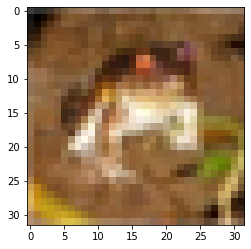

In [ ]:
plt.imshow(x_train[0])

In [ ]:
y_train[:10]

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], dtype=uint8)>

In [ ]:
#convert the labels to one hot vector
y_train=tf.one_hot(y_train,depth=10)
y_test=tf.one_hot(y_test,depth=10)

In [ ]:
y_train[:10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

#Building an image data pipeline

In [ ]:
def dataset_creater(x,y):
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(1024)#shuffle the data
    data=data.batch(32)#creat mini-batch
    data=data.prefetch(tf.data.AUTOTUNE)#This allows later elements to be prepared while the current element is being processed.     
    return data
train_dataset=dataset_creater(x_train,y_train)#create the train dataset
test_dataset=dataset_creater(x_test,y_test)#create the test dataset 

for x,y in train_dataset.take(1):#take the first batch
    x=x
    y=y
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (32, 32, 32, 3)
shape of y: (32, 10)


#Data Augmentation

In [ ]:
def data_ag(image, label):
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)

  image=tf.image.stateless_random_brightness(image,max_delta=32.0/255.0)
  image=tf.image.stateless_random_saturation(image,lower=0.5,upper=1.5)

  image = tf.clip_by_value(image, 0.0, 1.0)
  return image,label

In [ ]:
def dataset_creater(x,y):
    #Create a dataset that contains the images and labels
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(1024)#shuffle the data
    #data=data.map(data_ag,num_parallel_calls=tf.data.experimental.AUTOTUNE)#apply the preprocessing function to the data
    data=data.batch(32)#creat mini-batch
    data=data.prefetch(tf.data.experimental.AUTOTUNE)#This allows later elements to be prepared while the current element is being processed.
    
    return data
train_dataset=dataset_creater(x_train,y_train)#create the train dataset
test_dataset=dataset_creater(x_test,y_test)#create the test dataset    

In [ ]:
for x,y in train_dataset.take(1):#take the first batch
    x=x
    y=y
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (32, 32, 32, 3)
shape of y: (32, 10)


#Build the Model

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Input([32,32,3])
,tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Flatten()
,tf.keras.layers.Dense(256, activation='relu')
,tf.keras.layers.Dropout(0.3)
,tf.keras.layers.Dense(128, activation='relu')
,tf.keras.layers.Dropout(0.2)
,tf.keras.layers.Dense(10,activation=tf.nn.softmax)


]
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 128)       

#Compile and Train the Model

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])#compile the model

history = model.fit(train_dataset, epochs=20, 
                    validation_data=(test_dataset),callbacks=[tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)])#train the model and save the best model

Epoch 1/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.8256 - accuracy: 0.3715 - val_loss: 1.3791 - val_accuracy: 0.4962
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.3551 - accuracy: 0.5188 - val_loss: 1.1963 - val_accuracy: 0.5846
Epoch 3/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.2078 - accuracy: 0.5800 - val_loss: 1.1008 - val_accuracy: 0.6177
Epoch 4/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1007 - accuracy: 0.6212 - val_loss: 1.0411 - val_accuracy: 0.6408
Epoch 5/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0262 - accuracy: 0.6512 - val_loss: 1.0235 - val_accuracy: 0.6506
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9650 - accuracy: 0.6701 - val_loss: 0.9717 - val_accuracy: 0.6752
Epoch 7/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9044 - accuracy: 0.6898 - val_loss: 1.0002 -

In [ ]:
train_info=pd.DataFrame(history.history)
train_info

,loss,accuracy,val_loss,val_accuracy
0,1.825640,0.37154,1.379051,0.4962
1,1.355129,0.51878,1.196259,0.5846
2,1.207842,0.57996,1.100846,0.6177
3,1.100678,0.62122,1.041119,0.6408
4,1.026185,0.65118,1.023507,0.6506
5,0.964980,0.67010,0.971672,0.6752
6,0.904415,0.68978,1.000195,0.6703
7,0.876148,0.70106,0.938294,0.6847
8,0.831800,0.71818,0.933082,0.6885
9,0.797874,0.72736,0.944776,0.6909


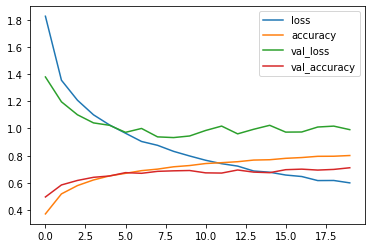

In [ ]:
train_info.plot.line()